In [1]:
# pip install beautifulsoup4    # Download and install beautiful soup 4
# pip install lxml              # Download and install lxml for its XML and HTML parser
# pip install requests          # Download and install Python requests module
# pip install seaborn           # Download and install Seaborn for visualizations

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import csv

import requests
import sys
import re

import sklearn
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

fund_house_count=3   # number of top fund houses to be analyzed
f_scheme_count=50    # Maximum number of fund schemes to be analyzed

money_control_root = 'http://www.moneycontrol.com'

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Get 10 mutual fund families with the highest Assets under Management from Money Control
markup = requests.get(money_control_root + '/mutual-funds/amc-assets-monitor').text

# make the soup
soup = BeautifulSoup(markup, "lxml")

# the table that contains the required data
table = soup.find_all('table', attrs = {"class": "tblfund1"})[0]

# get the first ten rows in this table, excluding
# the first row as it has only header information
rows = table.find_all('tr')[1:fund_house_count]


# Fund Family and Assets under Management (Rs. Cr.) for the top 10 mutual fund families
fund_families = []
for r in rows:
    ff_dict = {
        'fund_family_name': unicode( r.contents[1].a.string ),
        'fund_family_url' : unicode( money_control_root + r.contents[1].a.attrs['href'] ),
        'fund_family_aum' : unicode( r.contents[5].string ),
        'fund_family_shortcode' : unicode( money_control_root + r.contents[1].a.attrs['href'] ).split('/')[-1]
    }
    
    fund_families.append( ff_dict )

In [3]:
print( fund_families )

[{'fund_family_aum': u'342,291', 'fund_family_name': u'HDFC Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'fund_family_shortcode': u'HD'}]


In [4]:
# For each fund family, get a list of all fund schemes along with other details
fund_schemes = []
for fund in fund_families:
    
    markup = requests.get( fund['fund_family_url'] ).text

    soup = BeautifulSoup(markup, "lxml")

    rows = soup.select('.FL.MT10.boxBg table tr')[1:-1]
    
    for r in rows:
        data_elems      = r.find_all('td')
    
        category_name   = ''
        scheme_aum      = ''
        category_url    = ''
        
        try:
            category_name   = unicode( data_elems[2].a.string )
            category_url    = money_control_root + data_elems[2].a.attrs['href']
            
        except AttributeError:
            category_name   = u'None'
            category_url    = u'None'
    
        try:
            scheme_aum = unicode( data_elems[5].string )
        except AttributeError:
            scheme_aum = u'None'

        fscheme_dict    = {
            'fund_family_name'      : fund['fund_family_name'],
            'fund_family_url'       : fund['fund_family_url' ],
            'fund_family_aum'       : fund['fund_family_aum' ],
            'fund_family_shortcode' : fund['fund_family_shortcode'],
            'scheme_name'           : unicode( data_elems[0].a.string ),
            'scheme_url'            : money_control_root + data_elems[0].a.attrs['href'],
            'crisil_rating'         : unicode( data_elems[1].a.string ),
            'category'              : category_name,
            'category_url'          : category_url,
            'latest_nav'            : unicode( data_elems[3].string ),
            '1yr_return'            : u'None' if unicode( data_elems[4].string ) == u'--' else unicode( data_elems[4].string ),
            'scheme_aum'            : scheme_aum
        }

        fund_schemes.append( fscheme_dict )

In [40]:
print( len( fund_schemes ), '\n\n', fund_schemes[:1])

(10, '\n\n', [{'fund_family_aum': u'342,291', 'num_cat_avg_ret_6m': 3.13, 'Rank_within_cat_6m': u'15/21', 'num_fund_ret_3m': 1.73, 'num_cat_avg_ret_1m': 0.65, 'calculated_label_3y': 1.0, 'fund_family_shortcode': u'HD', 'scheme_plan': u'None', 'calculated_label_1m': 1.0, 'scheme_risk_text': u'Moderately Low', 'num_cat_avg_ret_2y': 6.36, 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'Rank_within_cat_2y': u'15/18', 'num_cat_avg_ret_1wk': 0.04, 'cat_avg_ret_3y': u'6.52%', 'calculated_label_1wk': 0.0, 'cat_avg_ret_3m': u'1.71%', 'cstm_mtrc_crisil': 0.6, 'Rank_within_cat_1y': u'13/19', 'num_cat_avg_ret_3y': 6.52, 'cstm_mtrc_diff_1m': 0, 'calculated_label_2y': 1.0, 'cat_avg_ret_1wk': u'0.04%', 'num_cat_avg_ret_3m': 1.71, 'cstm_mtrc_diff_1y': 0, 'Rank_within_cat_1m': u'9/24', 'latest_nav': u'22.39', 'Rank_within_cat_5y': u'9/11', 'cstm_mtrc_diff_1wk': 0, 'fund_ret_3y': u'20.51%', 'calculated_label_6m': 1.0, 'num_fund_ret_10y': None, 'cat_avg_ret_1y': u'6.37%', 

In [6]:
fund_schemes = fund_schemes[:f_scheme_count]


In [7]:
for idx, scheme in enumerate(fund_schemes):
    try:        
        # Read the page at the URL for each scheme
        markup = requests.get(scheme['scheme_url']).text
        soup = BeautifulSoup(markup, "lxml")

        # Riskometer (Risk Rating)
        scheme['scheme_risk_text'] = unicode(soup.select_one(".status").text)

        # Fund Category
        scheme['scheme_fund_type'] = unicode(soup.select_one(".sub_category_text").text)
        
        # Scheme Plan and Scheme Option
        scheme_plan_option_data    = [unicode( x.string ).strip() for x in soup.select('#planname_frm .FL span')]

        [scheme['scheme_plan'],
        scheme['scheme_option'] ] = scheme_plan_option_data if scheme_plan_option_data else [u'None', u'None']

        insert_position=scheme["scheme_url"].rfind('/')
        scheme['return_url'] = unicode(scheme["scheme_url"][:insert_position] + '/returns' + scheme["scheme_url"][insert_position:])
        #print(scheme['scheme_url'], scheme['return_url'])

        # markup2 = requests.get(scheme['return_url']).text
        # soup2 = BeautifulSoup(markup2, "lxml")
        returns_table = soup.find('table',{'class':'mctable1'})
        rows = returns_table.findAll('tr')

        for row in rows:
            row_attrs = [x for x in row.children if unicode(x).strip()]

            row_name  = unicode(row_attrs[0].string).strip().lower()

            # fund returns
            if row_name == '1 week':
                    scheme['fund_ret_1wk']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_1wk']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_1wk']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '1 month':
                    scheme['fund_ret_1m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_1m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_1m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '3 month':
                    scheme['fund_ret_3m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_3m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_3m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '6 month':
                    scheme['fund_ret_6m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_6m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_6m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '1 year':
                    scheme['fund_ret_1y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_1y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_1y']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '2 year':
                    scheme['fund_ret_2y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_2y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_2y']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '3 year':
                    scheme['fund_ret_3y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_3y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_3y']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '5 year':
                    scheme['fund_ret_5y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_5y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['Rank_within_cat_5y']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '10 year':
                    scheme['fund_ret_10y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_avg_ret_10y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )

            if row_name == 'since inception':
                    scheme['fund_ret_si']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )

        # Print every 100th scheme to verify things are running smoothly
        if idx % 100 == 0:
            print( 'Scheme # {0}\n{1}\n\n\n'.format(idx, scheme) )
        else:
            print idx, ' ',

    except:
        pass


Scheme # 0
{'fund_family_aum': u'342,291', 'Rank_within_cat_6m': u'15/21', 'fund_family_shortcode': u'HD', 'scheme_plan': u'None', 'scheme_risk_text': u'Moderately Low', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'Rank_within_cat_2y': u'15/18', 'cat_avg_ret_3y': u'6.52%', 'cat_avg_ret_3m': u'1.71%', 'Rank_within_cat_1y': u'13/19', 'cat_avg_ret_1wk': u'0.04%', 'Rank_within_cat_1m': u'9/24', 'latest_nav': u'22.39', 'Rank_within_cat_5y': u'9/11', 'fund_ret_3y': u'20.51%', 'cat_avg_ret_1y': u'6.37%', 'Rank_within_cat_1wk': u'15/24', '1yr_return': u'6.5', 'category_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-fund.html', 'fund_ret_3m': u'1.73%', 'cat_avg_ret_2y': u'6.36%', 'fund_ret_6m': u'3.10%', 'return_url': u'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-direct-plan/returns/MHD1171', 'fund_ret_10y': u'-', 'scheme_fund_type': u'Arbitrage Fund', 'fund_ret_1wk': u'0.03%', 'scheme_url': 'http://w

In [8]:

#Save the collected data to text, which is then converted to a csv file.

out_path= "./fund_schemes.csv"
out_file = open(out_path, 'wb')

fieldnames = sorted(list(set(k for d in fund_schemes for k in d)))
writer = csv.DictWriter(out_file, fieldnames=fieldnames, dialect='excel')

writer.writeheader() 
for row in fund_schemes:
    writer.writerow(row)
out_file.close()


'\n#Save the collected data to text, which is then converted to a csv file.\n\nout_path= "./fund_schemes.csv"\nout_file = open(out_path, \'wb\')\n\nfieldnames = sorted(list(set(k for d in fund_schemes for k in d)))\nwriter = csv.DictWriter(out_file, fieldnames=fieldnames, dialect=\'excel\')\n\nwriter.writeheader() \nfor row in fund_schemes:\n    writer.writerow(row)\nout_file.close()\n'

'\n# Read file\nin_path= "./fund_schemes.csv"\nin_file = open(in_path, \'r\')\nfund_schemes2=[]\nif in_file.mode == \'r\': \n    read_line = in_file.readlines()\n    for x in read_line:\n        fund_schemes2.append(x)\n'

In [10]:
'''
Method to convert risk text to a numerical attribute
'''
def encode_risk(risk_text):
    # The higher the risk, the lower the score!
    risk = {
        u'HIGH'              :  1,
        u'MODERATELY HIGH'   :  2,
        u'MODERATE'          :  3,
        u'MODERATELY LOW'    :  4,
        u'LOW'               :  5 
    }
    try:
        return risk[ unicode( risk_text.upper() ) ]
    except:
        return 0

'''
Method to convert numerical features that appear as strings or unicode strings into numbers
'''
def to_numeric( text ):
    try:
        return float( re.sub(
            '(Rs[ ]*\.)|[^\d|.|-]|(Rank[ ]*)',
            '',
            text,
            flags = re.IGNORECASE
        ) )
    except:
        return None

In [46]:
sum1=0
# Processing for ML
# Initialize a list to store metrics for risk
for idx, scheme in enumerate( fund_schemes ):
    ##
    # Step 1: Convert numerical features appearing as text to numerical features
    #         1.a: Encode risk text to a numerical representation of risk.
    #              Highest risk gets the lowest score, lowest risk gets the highest score
    #
    #         1.b: Convert numbers formatted with commas or currency or rating description to just numbers
    ##
    
    # Convert scheme risk text to a numerical attribute
    fund_schemes[idx]['num_scheme_risk']      = encode_risk( scheme['scheme_risk_text'] )/5
    
    # Convert metrics to numerical features
    fund_schemes[idx]['num_crisil_rating']    = to_numeric( scheme['crisil_rating'] )
    
    
    fund_schemes[idx]['num_fund_family_aum']  = to_numeric( scheme['fund_family_aum'] )
    fund_schemes[idx]['num_scheme_aum']       = to_numeric( scheme['scheme_aum'] ) if scheme['scheme_aum'] != u'None' else 0

    fund_schemes[idx]['num_fund_ret_10y']     = to_numeric( scheme['fund_ret_10y'] )
    fund_schemes[idx]['num_fund_ret_1m']      = to_numeric( scheme['fund_ret_1m'] )
    fund_schemes[idx]['num_fund_ret_1wk']     = to_numeric( scheme['fund_ret_1wk'] )
    fund_schemes[idx]['num_fund_ret_1y']      = to_numeric( scheme['fund_ret_1y'] )
    fund_schemes[idx]['num_fund_ret_2y']      = to_numeric( scheme['fund_ret_2y'] )
    fund_schemes[idx]['num_fund_ret_3m']      = to_numeric( scheme['fund_ret_3m'] )
    fund_schemes[idx]['num_fund_ret_3y']      = to_numeric( scheme['fund_ret_3y'] )
    fund_schemes[idx]['num_fund_ret_5y']      = to_numeric( scheme['fund_ret_5y'] )
    fund_schemes[idx]['num_fund_ret_6m']      = to_numeric( scheme['fund_ret_6m'] )
    fund_schemes[idx]['num_fund_ret_si']      = to_numeric( scheme['fund_ret_si'] )
    fund_schemes[idx]['num_latest_nav']       = to_numeric( scheme['latest_nav'] )

    fund_schemes[idx]['num_cat_avg_ret_10y']  = to_numeric( scheme['cat_avg_ret_10y'] )
    fund_schemes[idx]['num_cat_avg_ret_1m']   = to_numeric( scheme['cat_avg_ret_1m'] )
    fund_schemes[idx]['num_cat_avg_ret_1wk']  = to_numeric( scheme['cat_avg_ret_1wk'] )
    fund_schemes[idx]['num_cat_avg_ret_1y']   = to_numeric( scheme['cat_avg_ret_1y'] )
    fund_schemes[idx]['num_cat_avg_ret_2y']   = to_numeric( scheme['cat_avg_ret_2y'] )
    fund_schemes[idx]['num_cat_avg_ret_3m']   = to_numeric( scheme['cat_avg_ret_3m'] )
    fund_schemes[idx]['num_cat_avg_ret_3y']   = to_numeric( scheme['cat_avg_ret_3y'] )
    fund_schemes[idx]['num_cat_avg_ret_5y']   = to_numeric( scheme['cat_avg_ret_5y'] )
    fund_schemes[idx]['num_cat_avg_ret_6m']   = to_numeric( scheme['cat_avg_ret_6m'] )
    
    ##
    # Step 2: Calculate additional risk metrics - the fetched risk rating is based on MPT Statistics
    #         which is already a sound measurement. Hence, we devise and incorporate more measures
    #         such as:
    ##
    
    # Score between 0 and 1 based on Risk Rating which is based on MPT Statistics
    fund_schemes[idx]['cstm_mtrc_risk_rating'] = fund_schemes[idx]['num_scheme_risk'] / 5.0
    
    # Score between 0 and 1 based on CRISIL rating
    if scheme['num_crisil_rating'] == None:
        scheme['num_crisil_rating'] = 0.0

    fund_schemes[idx]['cstm_mtrc_crisil']  = fund_schemes[idx]['num_crisil_rating'] / 5.0 if fund_schemes[idx]['num_crisil_rating'] else 0
    
    # Score between 0 and 1 based on AUM allocation to the scheme compared to other schemes in the fund family
    fund_schemes[idx]['cstm_mtrc_alloc'] = float( fund_schemes[idx]['num_scheme_aum'] ) / ( fund_schemes[idx]['num_fund_family_aum'] - fund_schemes[idx]['num_scheme_aum'] )
    
    # Convert Rank within Categoty to numeric field between 0 to 1, 0 lowest rank, 1 higher rank
    try: 
        fund_schemes[idx]['cstm_mtrc_diff_1wk'] = 1 - float(scheme['Rank_within_cat_1wk'][:pos]) / float(scheme['Rank_within_cat_1wk'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_1wk'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_1m'] = 1 - float(scheme['Rank_within_cat_1m'][:pos]) / float(scheme['Rank_within_cat_1m'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_1m'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_3m'] = 1 - float(scheme['Rank_within_cat_3m'][:pos]) / float(scheme['Rank_within_cat_3m'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_3m'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_6m'] = 1 - float(scheme['Rank_within_cat_6m'][:pos]) / float(scheme['Rank_within_cat_6m'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_6m'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_1y'] = 1- float(scheme['Rank_within_cat_1y'][:pos]) / float(scheme['Rank_within_cat_1y'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_1y'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_2y'] = 1 - float(scheme['Rank_within_cat_2y'][:pos]) / float(scheme['Rank_within_cat_2y'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_2y'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_3y'] = 1 - float(scheme['Rank_within_cat_3y'][:pos]) / float(scheme['Rank_within_cat_3y'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_3y'] = 0

    try: 
        fund_schemes[idx]['cstm_mtrc_diff_5y'] = 1 - float(scheme['Rank_within_cat_5y'][:pos]) / float(scheme['Rank_within_cat_5y'][pos+1:])
    except:
        fund_schemes[idx]['cstm_mtrc_diff_5y'] = 0

        
    # Initialize a set of lists to contain class labels based on time frame
    normal_scores_1wk = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1wk']
    ]
    
    normal_scores_1m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1m']
    ]
    
    normal_scores_3m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_3m']
    ]
    
    normal_scores_6m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_6m']
    ]
    
    normal_scores_1y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1y']
    ]
    
    normal_scores_2y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_2y']
    ]
    
    normal_scores_3y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_3y']
    ]
    
    normal_scores_5y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_5y']
    ]
    

    ##
    # Calculate labels for each time frame based on calculated metrics
    ## 
    ##
    labels_1wk = round( float( sum(normal_scores_1wk ) ) / max( len( normal_scores_1wk ), 1 ) )
    labels_1m = round( float( sum(normal_scores_1m ) +1.5 ) / max( len( normal_scores_1m ), 1 ) )
    labels_3m = round( float( sum(normal_scores_3m ) +1.5 ) / max( len( normal_scores_3m ), 1 ) )
    labels_6m = round( float( sum(normal_scores_6m ) +1.5 ) / max( len( normal_scores_6m ), 1 ) )
    labels_1y = round( float( sum(normal_scores_1y ) +1.5) / max( len( normal_scores_1y ), 1 ) )
    labels_2y = round( float( sum(normal_scores_2y ) +1.5) / max( len( normal_scores_2y ), 1 ) )
    labels_3y = round( float( sum(normal_scores_3y ) +1.5) / max( len( normal_scores_3y ), 1 ) )
    labels_5y = round( float( sum(normal_scores_5y ) +1.5) / max( len( normal_scores_5y ), 1 ) )

    '''    
    labels_1wk = round( float( sum(normal_scores_1wk ) ) / max( len( normal_scores_1wk ), 1 ) )
    labels_1m = round( float( sum(normal_scores_1m ) ) / max( len( normal_scores_1m ), 1 ) )
    labels_3m = round( float( sum(normal_scores_3m ) ) / max( len( normal_scores_3m ), 1 ) )
    labels_6m = round( float( sum(normal_scores_6m ) ) / max( len( normal_scores_6m ), 1 ) )
    labels_1y = round( float( sum(normal_scores_1y ) ) / max( len( normal_scores_1y ), 1 ) )
    labels_2y = round( float( sum(normal_scores_2y ) ) / max( len( normal_scores_2y ), 1 ) )
    labels_3y = round( float( sum(normal_scores_3y ) ) / max( len( normal_scores_3y ), 1 ) )
    labels_5y = round( float( sum(normal_scores_5y ) ) / max( len( normal_scores_5y ), 1 ) )
    '''

    # Store the labels for each time frame along with scheme details
    fund_schemes[idx]['calculated_label_1wk'] = labels_1wk
    fund_schemes[idx]['calculated_label_1m'] = labels_1m
    fund_schemes[idx]['calculated_label_3m'] = labels_3m
    fund_schemes[idx]['calculated_label_6m'] = labels_6m
    fund_schemes[idx]['calculated_label_1y'] = labels_1y
    fund_schemes[idx]['calculated_label_2y'] = labels_2y
    fund_schemes[idx]['calculated_label_3y'] = labels_3y
    fund_schemes[idx]['calculated_label_5y'] = labels_5y
    
    sum1 =+ labels_1wk + labels_1m + labels_3m + labels_6m + labels_1y + labels_2y + labels_3y + labels_5y
    print(labels_1wk, labels_1m, labels_3m, labels_6m, labels_1y, labels_2y, labels_3y, labels_5y)


(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


In [47]:

print(round( float( sum(normal_scores_1m ) )))
print( max( len( normal_scores_1m ), 1 ))
print(round( float( sum(normal_scores_1m ) ) / max( len( normal_scores_1m ), 1 ) ))
print(labels_1m)
print(sum1)

0.0
4
0.0
0.0
0.0


"\nsome_val = list()\nfor scheme in fund_schemes:\n\n        \n    if scheme['num_crisil_rating'] not in some_val:\n        some_val.append( scheme['num_crisil_rating'] )\n    \nprint set( some_val )\n"

"\nimport csv\n\nkeys = to_csv[0].keys()\nwith open('funds.csv', 'wb') as output_file:\n    dict_writer = csv.DictWriter(output_file, keys)\n    dict_writer.writeheader()\n    dict_writer.writerows(toCSV)\n"

In [48]:
##
# Create target values for each time frame
##
Y_1wk = np.array( [scheme['calculated_label_1wk'] for scheme in fund_schemes] )
Y_1m = np.array( [scheme['calculated_label_1m'] for scheme in fund_schemes] )
Y_3m = np.array( [scheme['calculated_label_3m'] for scheme in fund_schemes] )
Y_6m = np.array( [scheme['calculated_label_6m'] for scheme in fund_schemes] )
Y_1y = np.array( [scheme['calculated_label_1y'] for scheme in fund_schemes] )
Y_2y = np.array( [scheme['calculated_label_2y'] for scheme in fund_schemes] )
Y_3y = np.array( [scheme['calculated_label_3y'] for scheme in fund_schemes] )
Y_5y = np.array( [scheme['calculated_label_5y'] for scheme in fund_schemes] )


In [80]:
print(Y_1wk)
print(Y_1m)
print(Y_3m)
print(Y_6m)
print(Y_1y)
print(Y_2y)
print(Y_3y)
print(Y_5y)




[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]


In [51]:
##
# Create feature vectors for each time frame
##
X_1wk = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_1wk']           if scheme['num_fund_ret_1wk'] else 0,
            scheme['num_cat_avg_ret_1wk']        if scheme['num_cat_avg_ret_1wk'] else 0
        ]
        for scheme in fund_schemes
    ]
)

X_1m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_1m'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_1m'] else 0
        ]
        for scheme in fund_schemes
    ]
)

X_3m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_3m']           if scheme['num_fund_ret_3m'] else 0,
            scheme['num_cat_avg_ret_3m']        if scheme['num_cat_avg_ret_3m'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_6m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_6m']           if scheme['num_fund_ret_6m'] else 0,
            scheme['num_cat_avg_ret_6m']        if scheme['num_cat_avg_ret_6m'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_1y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_1y']           if scheme['num_fund_ret_1y'] else 0,
            scheme['num_cat_avg_ret_1y']        if scheme['num_cat_avg_ret_1y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_2y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_2y']           if scheme['num_fund_ret_2y'] else 0,
            scheme['num_cat_avg_ret_2y']        if scheme['num_cat_avg_ret_2y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_3y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_3y']           if scheme['num_fund_ret_3y'] else 0,
            scheme['num_cat_avg_ret_3y']        if scheme['num_cat_avg_ret_3y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_5y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_5y']           if scheme['num_fund_ret_5y'] else 0,
            scheme['num_cat_avg_ret_5y']        if scheme['num_cat_avg_ret_5y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)



# Handle NaNs using an Imputer
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

X_1wk = imp.fit_transform( X_1wk )
X_1m = imp.fit_transform( X_1m )
X_3m = imp.fit_transform( X_3m )
X_6m = imp.fit_transform( X_6m )
X_1y = imp.fit_transform( X_1y )
X_2y = imp.fit_transform( X_2y )
X_3y = imp.fit_transform( X_3y )
X_5y = imp.fit_transform( X_5y )


In [ ]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 30
# to find out which trees gives more accuracy.

num_trees = range(1, 31)

# Define folds = N for N-fold cross-validation
num_folds = 5

# Define a DF to store cross validation results
df_rf_1y = pd.DataFrame()
df_rf_5y = pd.DataFrame()

df_rf_1y['num_trees'] = [0]  * len( num_trees )
df_rf_1y['scores']    = [[]] * len( num_trees )

df_rf_5y['num_trees'] = [0]  * len( num_trees )
df_rf_5y['scores']    = [[]] * len( num_trees )

# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in num_trees:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = num)
    
    scores_1y = sklearn.cross_validation.cross_val_score(forest, X_1y[:1000, :], Y_1y[:1000], scoring = 'f1', cv = num_folds)
    scores_5y = sklearn.cross_validation.cross_val_score(forest, X_5y[:1000, :], Y_5y[:1000], scoring = 'f1', cv = num_folds)
    
    df_rf_1y['num_trees'][ num - 1] = num
    df_rf_5y['num_trees'][ num - 1] = num
    
    df_rf_1y['scores'][ num - 1] = scores_1y
    df_rf_5y['scores'][ num - 1] = scores_5y


In [83]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 30
# to find out which trees gives more accuracy.

num_trees = range(1, 31)

# Define folds = N for N-fold cross-validation
num_folds = 5

# Define a DF to store cross validation results
df_rf_1wk = pd.DataFrame()
df_rf_1m = pd.DataFrame()
df_rf_3m = pd.DataFrame()
df_rf_6m = pd.DataFrame()
df_rf_1y = pd.DataFrame()
df_rf_2y = pd.DataFrame()
df_rf_3y = pd.DataFrame()
df_rf_5y = pd.DataFrame()

df_rf_1wk['num_trees'] = [0]  * len( num_trees )
df_rf_1wk['scores']    = [[]] * len( num_trees )

df_rf_1m['num_trees'] = [0]  * len( num_trees )
df_rf_1m['scores']    = [[]] * len( num_trees )

df_rf_3m['num_trees'] = [0]  * len( num_trees )
df_rf_3m['scores']    = [[]] * len( num_trees )

df_rf_6m['num_trees'] = [0]  * len( num_trees )
df_rf_6m['scores']    = [[]] * len( num_trees )

df_rf_1y['num_trees'] = [0]  * len( num_trees )
df_rf_1y['scores']    = [[]] * len( num_trees )

df_rf_2y['num_trees'] = [0]  * len( num_trees )
df_rf_2y['scores']    = [[]] * len( num_trees )

df_rf_3y['num_trees'] = [0]  * len( num_trees )
df_rf_3y['scores']    = [[]] * len( num_trees )

df_rf_5y['num_trees'] = [0]  * len( num_trees )
df_rf_5y['scores']    = [[]] * len( num_trees )

# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in num_trees:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = num)
    
    scores_1wk = sklearn.cross_validation.cross_val_score(forest, X_1wk[:1000, :], Y_1wk[:1000], scoring = 'f1', cv = num_folds)
    scores_1m = sklearn.cross_validation.cross_val_score(forest, X_1m[:1000, :], Y_1m[:1000], scoring = 'f1', cv = num_folds)
    scores_3m = sklearn.cross_validation.cross_val_score(forest, X_3m[:1000, :], Y_3m[:1000], scoring = 'f1', cv = num_folds)
    scores_6m = sklearn.cross_validation.cross_val_score(forest, X_6m[:1000, :], Y_6m[:1000], scoring = 'f1', cv = num_folds)
    scores_1y = sklearn.cross_validation.cross_val_score(forest, X_1y[:1000, :], Y_1y[:1000], scoring = 'f1', cv = num_folds)
    scores_2y = sklearn.cross_validation.cross_val_score(forest, X_2y[:1000, :], Y_2y[:1000], scoring = 'f1', cv = num_folds)
    scores_3y = sklearn.cross_validation.cross_val_score(forest, X_3y[:1000, :], Y_3y[:1000], scoring = 'f1', cv = num_folds)
    scores_5y = sklearn.cross_validation.cross_val_score(forest, X_5y[:1000, :], Y_5y[:1000], scoring = 'f1', cv = num_folds)
    
    df_rf_1wk['num_trees'][ num - 1] = num
    df_rf_1m['num_trees'][ num - 1] = num
    df_rf_3m['num_trees'][ num - 1] = num
    df_rf_6m['num_trees'][ num - 1] = num
    df_rf_1y['num_trees'][ num - 1] = num
    df_rf_2y['num_trees'][ num - 1] = num
    df_rf_3y['num_trees'][ num - 1] = num
    df_rf_5y['num_trees'][ num - 1] = num
    
    df_rf_1wk['scores'][ num - 1] = scores_1wk
    df_rf_1m['scores'][ num - 1] = scores_1m
    df_rf_3m['scores'][ num - 1] = scores_3m
    df_rf_6m['scores'][ num - 1] = scores_6m
    df_rf_1y['scores'][ num - 1] = scores_1y
    df_rf_2y['scores'][ num - 1] = scores_2y
    df_rf_3y['scores'][ num - 1] = scores_3y
    df_rf_5y['scores'][ num - 1] = scores_5y


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [84]:
print(df_rf_5y.scores)

0                           [1.0, 0.0, 1.0, 1.0, 1.0]
1                [0.666666666667, 0.0, 1.0, 1.0, 1.0]
2                [0.666666666667, 0.0, 1.0, 1.0, 1.0]
3                [0.666666666667, 0.0, 1.0, 1.0, 1.0]
4                [0.666666666667, 1.0, 1.0, 1.0, 1.0]
5                [0.666666666667, 0.0, 1.0, 1.0, 1.0]
6                [0.666666666667, 0.0, 1.0, 1.0, 1.0]
7                [0.666666666667, 1.0, 1.0, 1.0, 1.0]
8     [0.666666666667, 1.0, 1.0, 1.0, 0.666666666667]
9                [0.666666666667, 1.0, 1.0, 1.0, 1.0]
10               [0.666666666667, 1.0, 1.0, 1.0, 1.0]
11               [0.666666666667, 1.0, 1.0, 1.0, 1.0]
12               [0.666666666667, 1.0, 1.0, 1.0, 1.0]
13               [0.666666666667, 0.0, 1.0, 1.0, 1.0]
14               [0.666666666667, 0.0, 1.0, 1.0, 1.0]
15                          [1.0, 1.0, 1.0, 1.0, 1.0]
16               [0.666666666667, 0.0, 1.0, 1.0, 1.0]
17               [0.666666666667, 0.0, 1.0, 1.0, 1.0]
18               [0.66666666

In [85]:
print(df_rf_1wk.num_trees.values)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30]


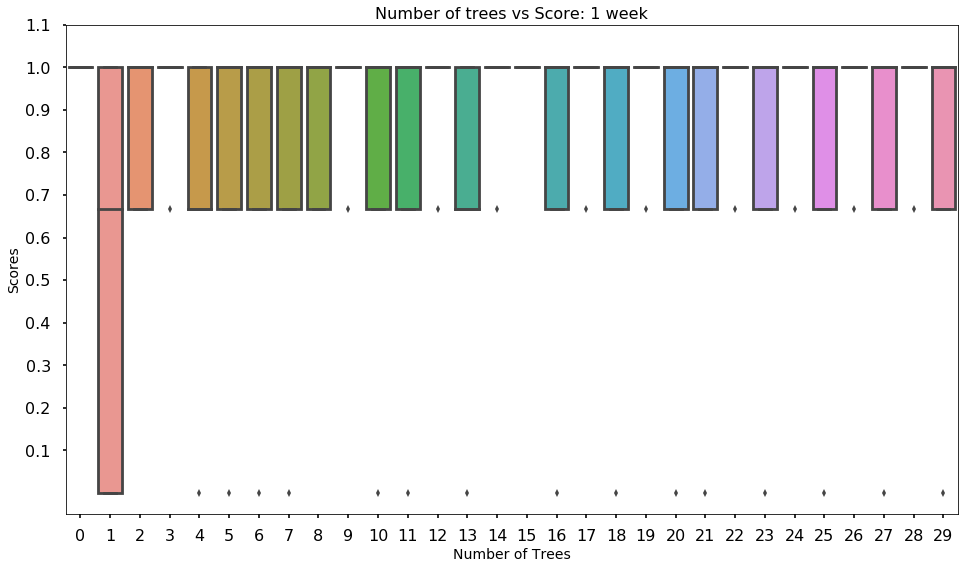

In [86]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
#sns.boxplot(data  = df_rf_1wk.scores, names = df_rf_1wk.num_trees.values )
sns.boxplot(data  = df_rf_1wk.scores)


plt.title(  "Number of trees vs Score: 1 week", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


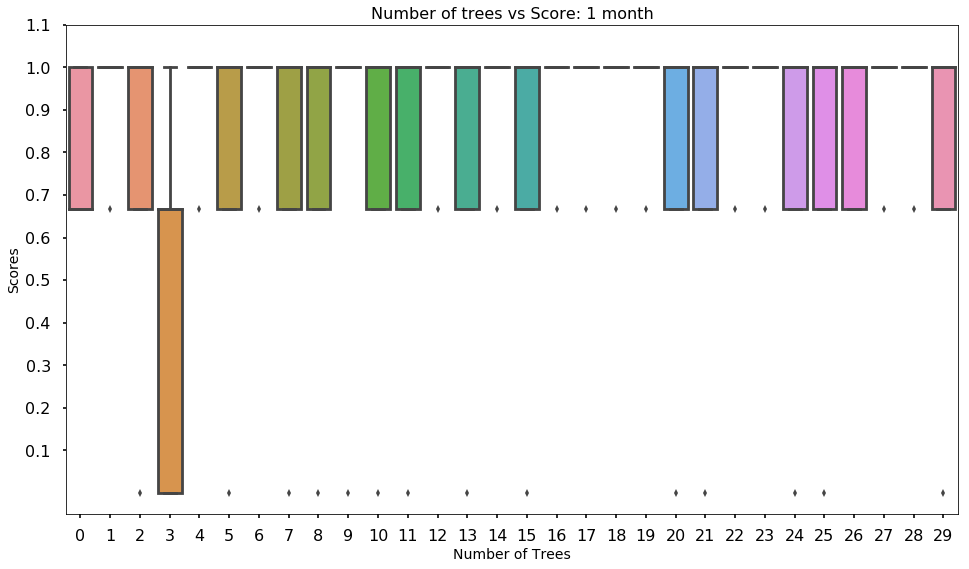

In [87]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
#sns.boxplot(data  = df_rf_1m.scores, names = df_rf_1m.num_trees.values )
sns.boxplot(data  = df_rf_1m.scores)

plt.title(  "Number of trees vs Score: 1 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


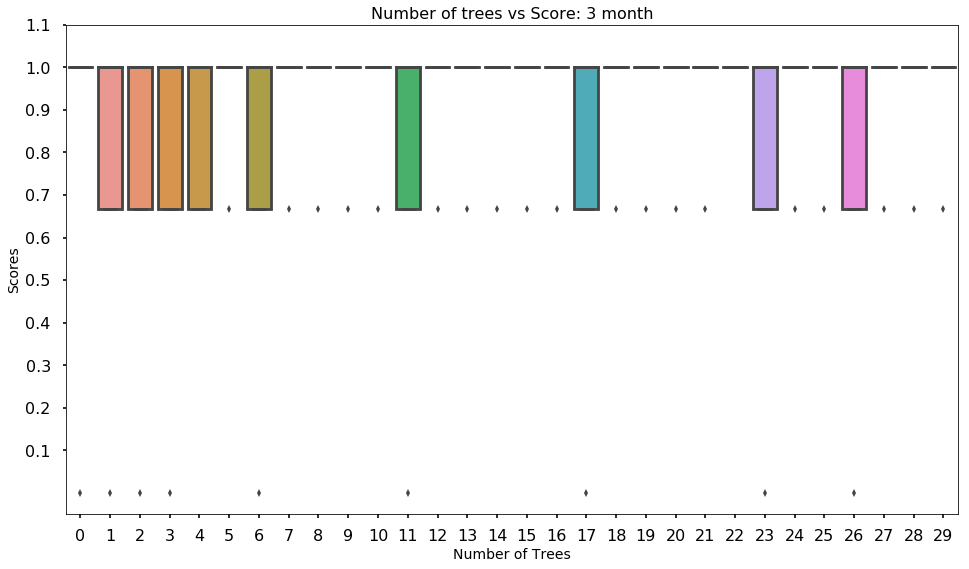

In [88]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_3m.scores)

plt.title(  "Number of trees vs Score: 3 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


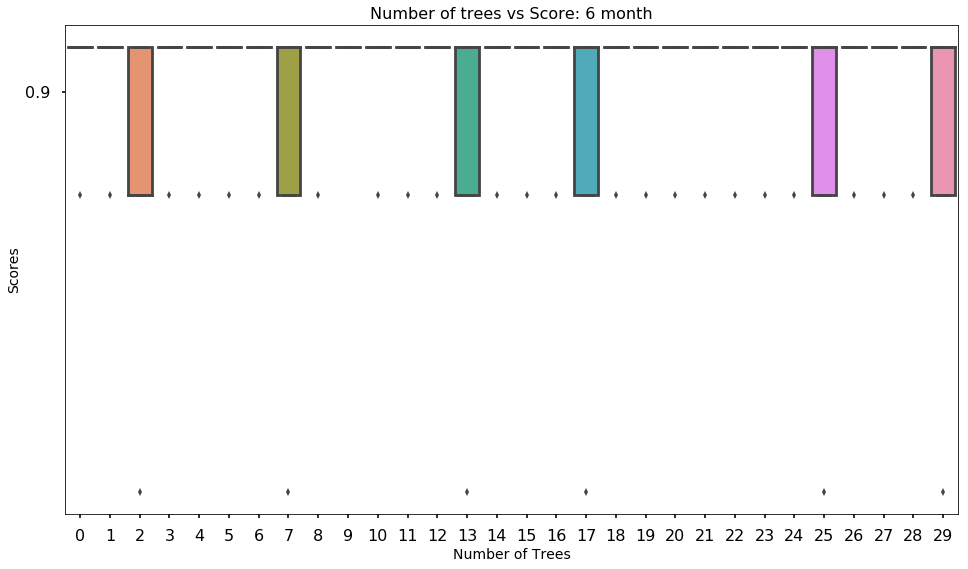

In [89]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot

sns.boxplot(data  = df_rf_6m.scores)

plt.title(  "Number of trees vs Score: 6 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


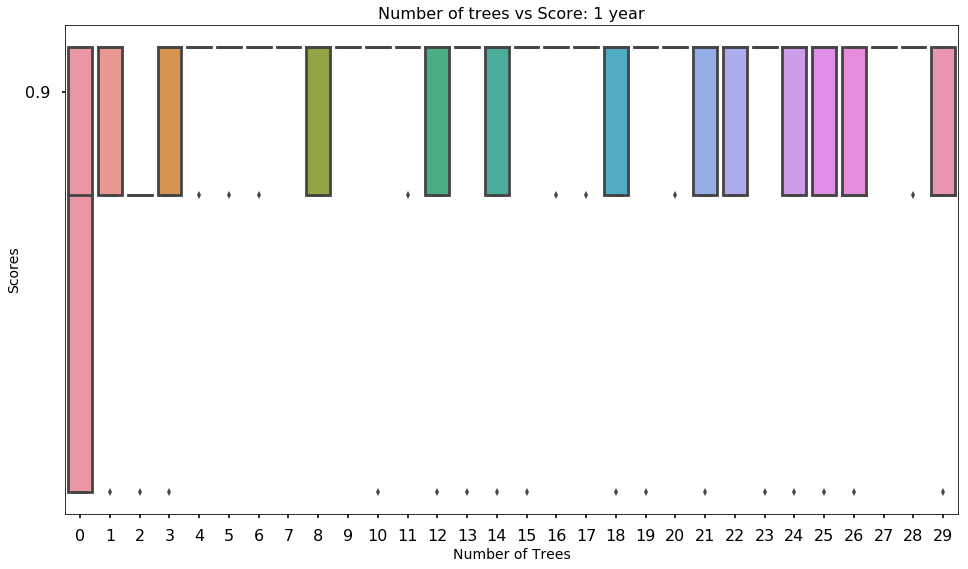

In [90]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_1y.scores)

plt.title(  "Number of trees vs Score: 1 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


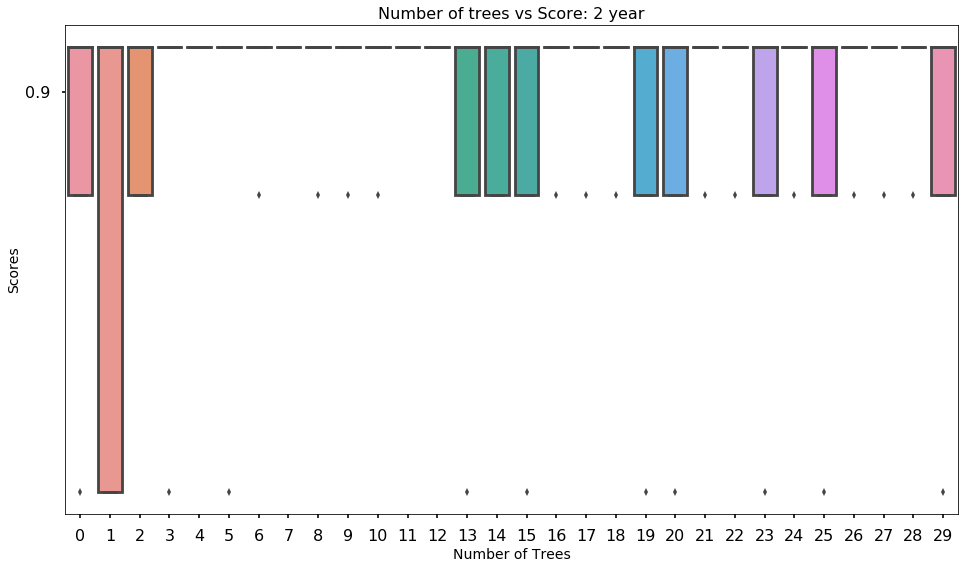

In [91]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_2y.scores)

plt.title(  "Number of trees vs Score: 2 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


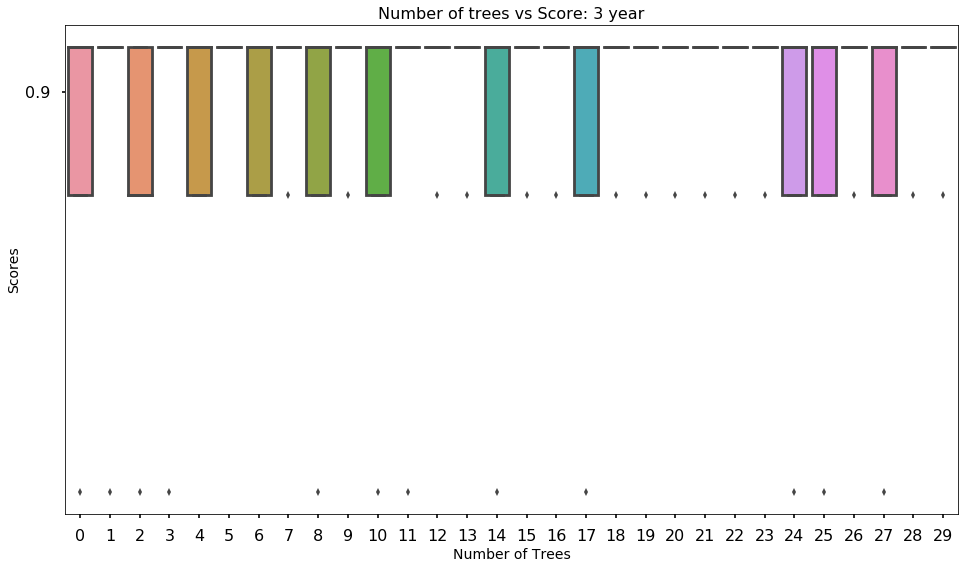

In [92]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_3y.scores)

plt.title(  "Number of trees vs Score: 3 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


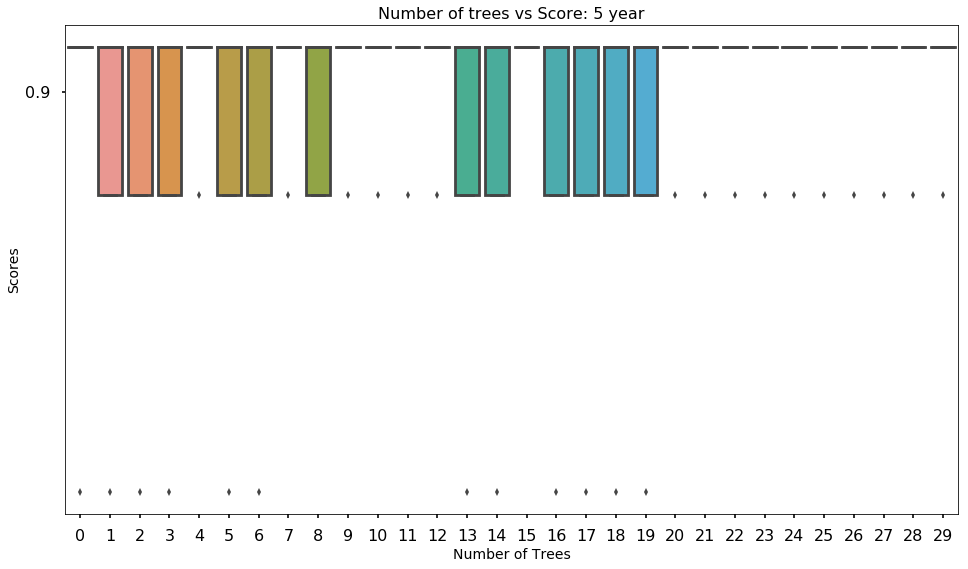

In [93]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_5y.scores)

plt.title(  "Number of trees vs Score: 5 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


In [94]:
##
# 1 week:
##
# Train random forest classifier with the optimal 27 estimators
## 

clf_1wk = sklearn.ensemble.RandomForestClassifier( n_estimators = 27)
clf_1wk = clf_1wk.fit( X_1wk[:1000, :], Y_1wk[:1000] )


##
# 1 month:
##
# Train random forest classifier with the optimal 27 estimators
## 

clf_1m = sklearn.ensemble.RandomForestClassifier( n_estimators = 27)
clf_1m = clf_1m.fit( X_1m[:1000, :], Y_1m[:1000] )

##
# 3 month:
##
# Train random forest classifier with the optimal 3 estimators
## 
clf_3m = sklearn.ensemble.RandomForestClassifier( n_estimators = 3)
clf_3m = clf_3m.fit( X_3m[:1000, :], Y_3m[:1000] )

##
# 6 month:
##
# Train random forest classifier with the optimal 2 estimators
## 
clf_6m = sklearn.ensemble.RandomForestClassifier( n_estimators = 2)
clf_6m = clf_6m.fit( X_6m[:1000, :], Y_6m[:1000] )

##
# 1 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clf_1y = sklearn.ensemble.RandomForestClassifier( n_estimators = 20)
clf_1y = clf_1y.fit( X_1y[:1000, :], Y_1y[:1000] )

##
# 2 year:
##
# Train random forest classifier with the optimal 8 estimators
## 
clf_2y = sklearn.ensemble.RandomForestClassifier( n_estimators = 8)
clf_2y = clf_2y.fit( X_2y[:1000, :], Y_2y[:1000] )

##
# 3 year:
##
# Train random forest classifier with the optimal 3 estimators
## 
clf_3y = sklearn.ensemble.RandomForestClassifier( n_estimators = 3)
clf_3y = clf_3y.fit( X_3y[:1000, :], Y_3y[:1000] )

##
# 5 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clf_5y = sklearn.ensemble.RandomForestClassifier( n_estimators = 20)
clf_5y = clf_5y.fit( X_5y[:1000, :], Y_5y[:1000] )



# obtain the relative importance of the features 
feature_imp_1wk = clf_1m.feature_importances_
feature_imp_1m = clf_1m.feature_importances_
feature_imp_3m = clf_3m.feature_importances_
feature_imp_6m = clf_6m.feature_importances_
feature_imp_1y = clf_1y.feature_importances_
feature_imp_2y = clf_2y.feature_importances_
feature_imp_3y = clf_3y.feature_importances_
feature_imp_5y = clf_5y.feature_importances_

#get column names
columns = ['Scheme Risk',
            'CRISIL Rating',
            'Fund Family AUM',
            'Scheme AUM',
            'Latest NAV',
            'Fund Return',
            'Category Return'
          ]

# Diagnostics - Check relative importance of features
print feature_imp_1wk
print feature_imp_1m
print feature_imp_3m
print feature_imp_6m
print feature_imp_1y
print feature_imp_2y
print feature_imp_3y
print feature_imp_5y


# Plot feature importances for each time frame
index = np.arange( len(columns) - 1 )
bar_width = 0.3
opacity = 0.5

[ 0.          0.24584803  0.          0.11204194  0.27859592  0.20496767
  0.15854644]
[ 0.          0.24584803  0.          0.11204194  0.27859592  0.20496767
  0.15854644]
[ 0.          0.          0.          0.          0.78571429  0.16468254
  0.04960317]
[ 0.          0.28571429  0.          0.28571429  0.21428571  0.21428571
  0.        ]
[ 0.          0.35952381  0.          0.03928571  0.30138889  0.15069444
  0.14910714]
[ 0.          0.25        0.          0.05555556  0.39146825  0.16607143
  0.13690476]
[ 0.          0.33333333  0.          0.          0.          0.52380952
  0.14285714]
[ 0.          0.17111111  0.          0.05160714  0.12777778  0.3889881
  0.26051587]


In [95]:
index = np.arange(6)
print(index)
print(feature_imp_1m)

[0 1 2 3 4 5]
[ 0.          0.24584803  0.          0.11204194  0.27859592  0.20496767
  0.15854644]


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


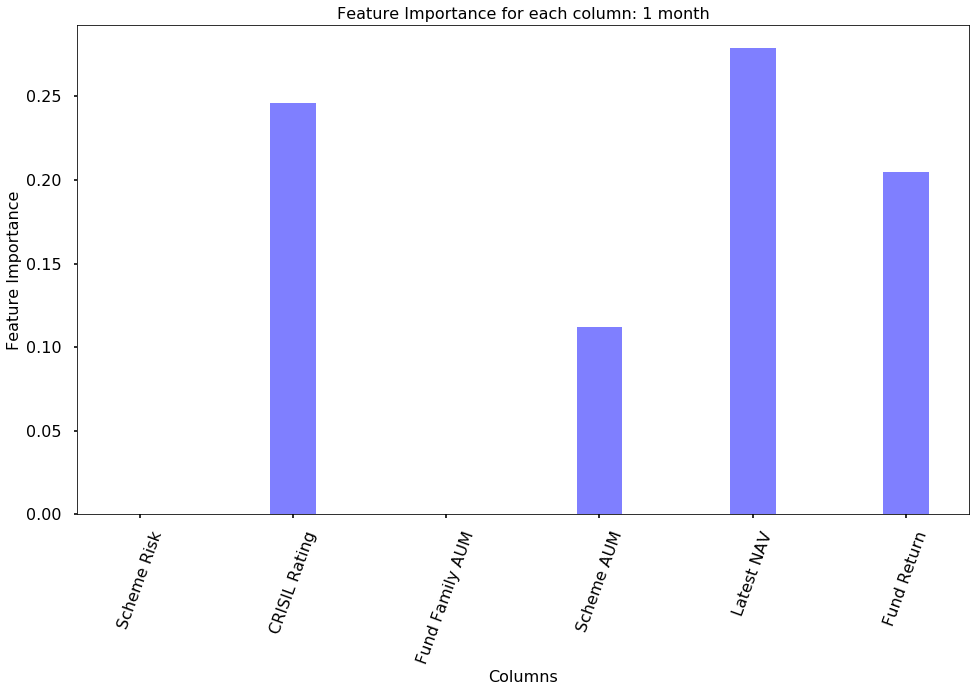

In [96]:
# 1 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_1m, [6, 7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


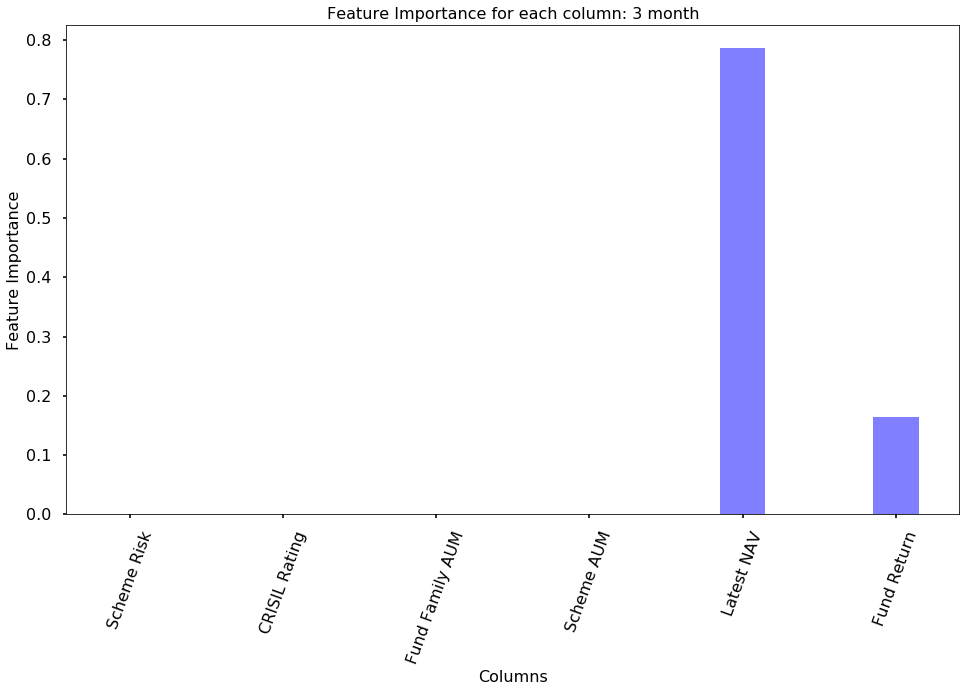

In [97]:
# 3 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_3m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


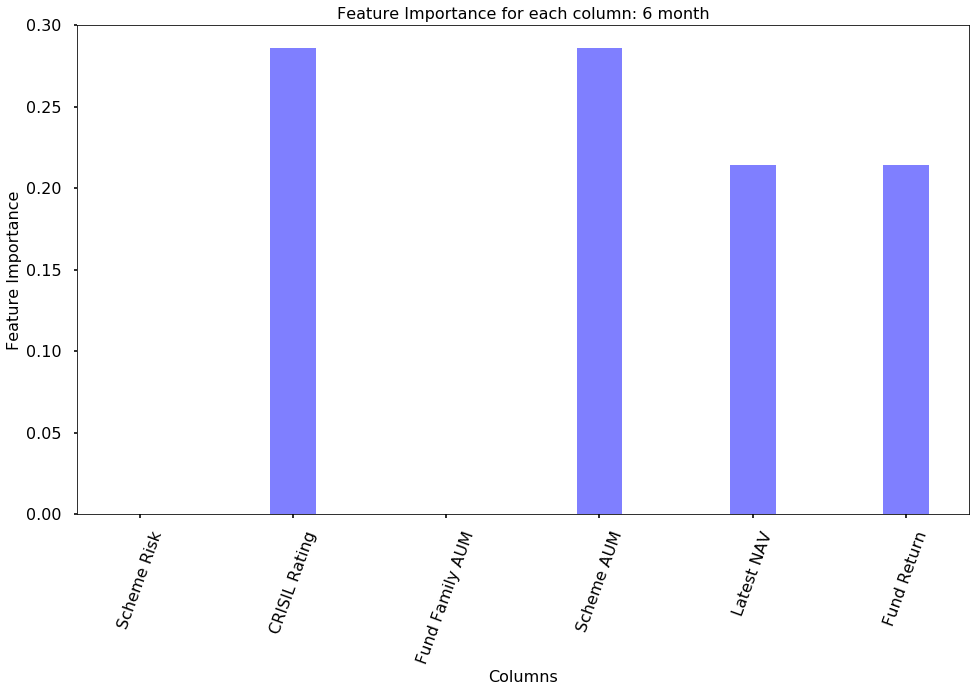

In [98]:
# 6 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_6m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 6 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


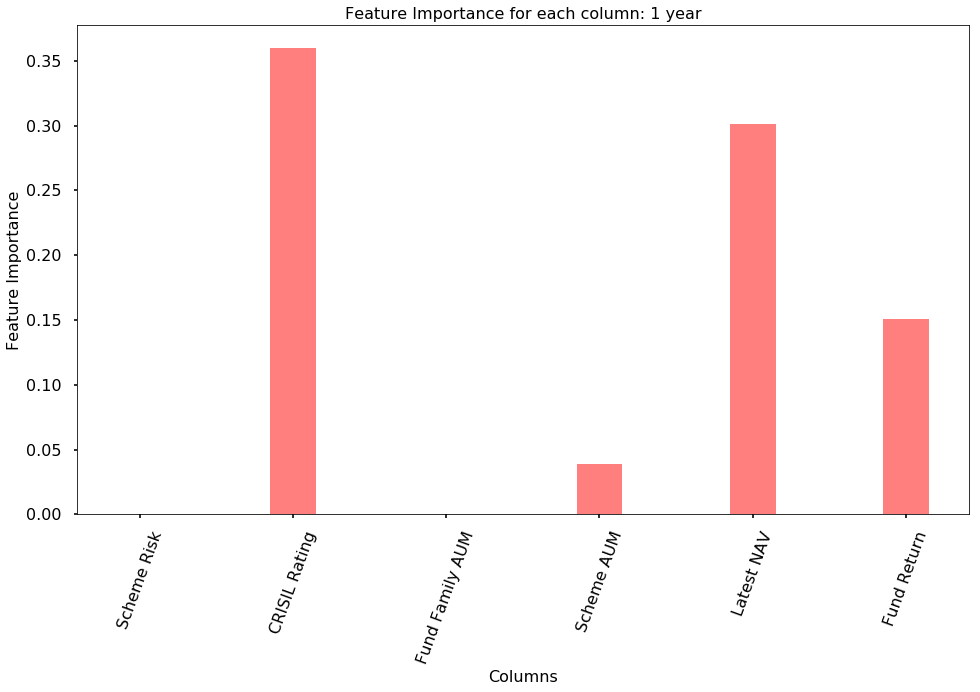

In [99]:
# 1 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_1y, [6,7]),
        bar_width,
        alpha=opacity,
        color='r',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


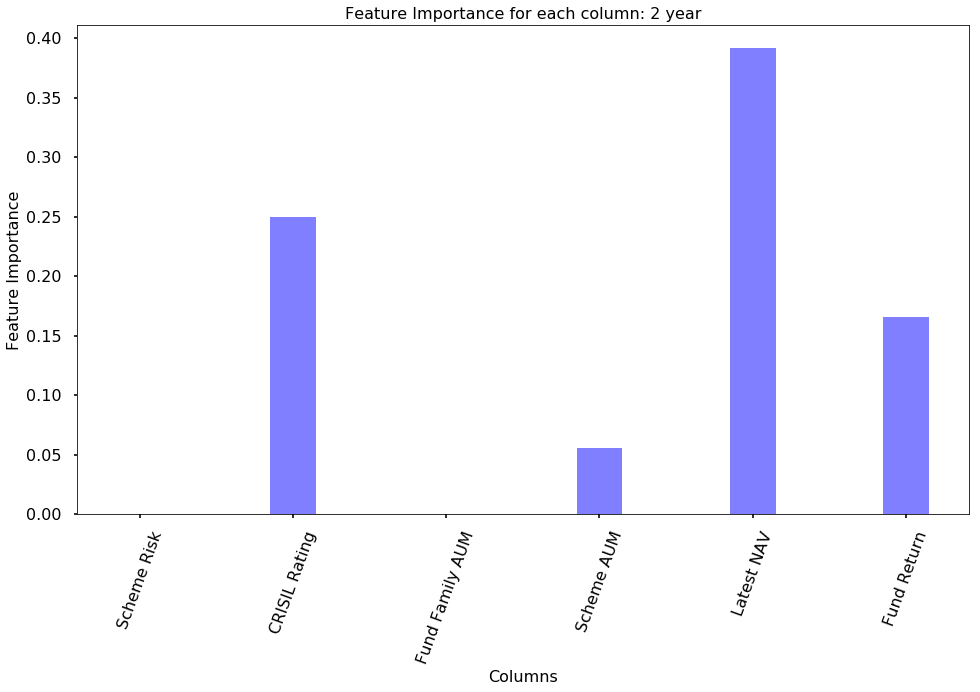

In [100]:
# 2 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_2y, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 2 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


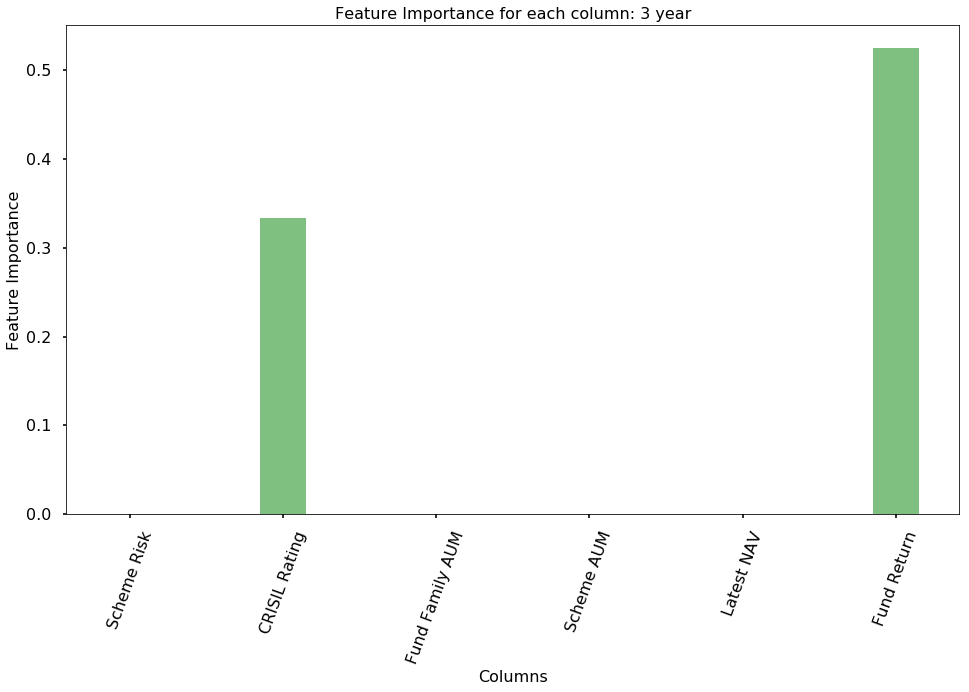

In [101]:
# 3 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_3y, [6,7]),
        bar_width,
        alpha=opacity,
        color='g',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


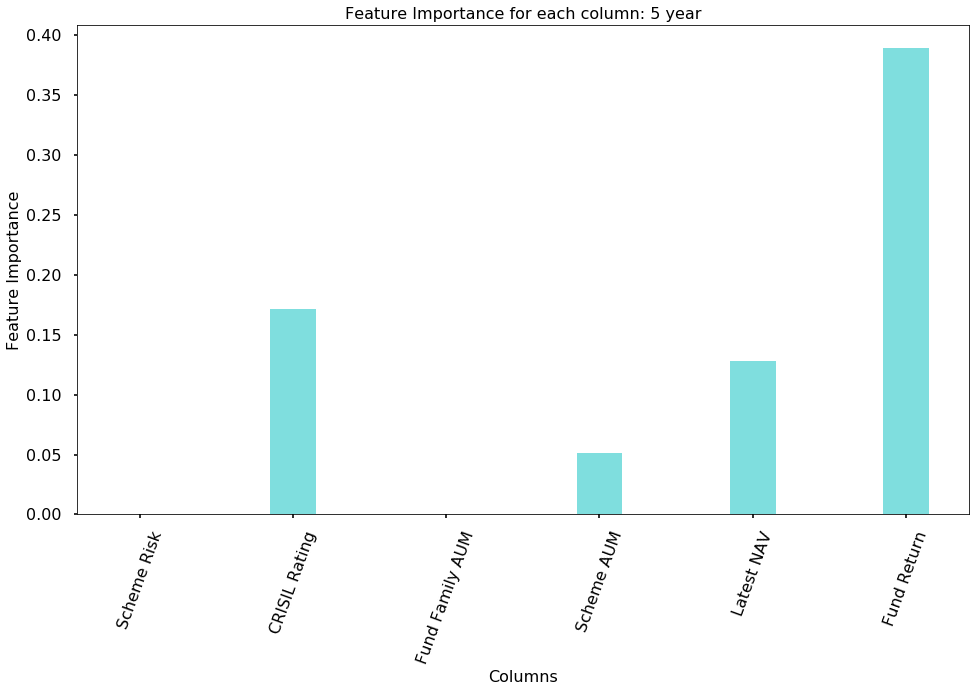

In [102]:
# 5 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_5y, [6,7]),
        bar_width,
        alpha=opacity,
        color='c',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 5 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

In [110]:
##
# Predict good and bad fund based on Random Forest Classification
##
Y_1wk_predicted = clf_1wk.predict( X_1wk )
Y_1m_predicted = clf_1m.predict( X_1m )
Y_3m_predicted = clf_3m.predict( X_3m )
Y_6m_predicted = clf_6m.predict( X_6m )
Y_1y_predicted = clf_1y.predict( X_1y )
Y_2y_predicted = clf_2y.predict( X_2y )
Y_3y_predicted = clf_3y.predict( X_3y )
Y_5y_predicted = clf_5y.predict( X_5y )

In [112]:
print(X_1wk[1000:, :])
print(Y_1wk[1000:])
print(clf_1wk)

[]
[]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [ ]:
##
# Model Evaluation: Classification Score
##
clf_1wk_score = clf_1wk.score(X_1wk[1000:, :], Y_1wk[1000:], sample_weight=None)
clf_1m_score = clf_1m.score(X_1m[1000:, :], Y_1m[1000:], sample_weight=None)
clf_3m_score = clf_3m.score(X_3m[1000:, :], Y_3m[1000:], sample_weight=None)
clf_6m_score = clf_6m.score(X_6m[1000:, :], Y_6m[1000:], sample_weight=None)
clf_1y_score = clf_1y.score(X_1y[1000:, :], Y_1y[1000:], sample_weight=None)
clf_2y_score = clf_2y.score(X_2y[1000:, :], Y_2y[1000:], sample_weight=None)
clf_3y_score = clf_3y.score(X_3y[1000:, :], Y_3y[1000:], sample_weight=None)
clf_5y_score = clf_5y.score(X_5y[1000:, :], Y_5y[1000:], sample_weight=None)

In [ ]:
print('Timeframe: {0}\nScore: {1}\n'.format('1m', clf_1m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3m', clf_3m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('6m', clf_6m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('1y', clf_1y_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('2y', clf_2y_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3y', clf_3y_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('5y', clf_5y_score) )

In [106]:
## 
# List of good funds for each time frame
## 
good_funds_1m = [ fund_schemes[k] for (k, v) in enumerate( Y_1m_predicted ) if v == 1.0 ]
good_funds_3m = [ fund_schemes[k] for (k, v) in enumerate( Y_3m_predicted ) if v == 1.0 ]
good_funds_6m = [ fund_schemes[k] for (k, v) in enumerate( Y_6m_predicted ) if v == 1.0 ]
good_funds_1y = [ fund_schemes[k] for (k, v) in enumerate( Y_1y_predicted ) if v == 1.0 ]
good_funds_2y = [ fund_schemes[k] for (k, v) in enumerate( Y_2y_predicted ) if v == 1.0 ]
good_funds_3y = [ fund_schemes[k] for (k, v) in enumerate( Y_3y_predicted ) if v == 1.0 ]
good_funds_5y = [ fund_schemes[k] for (k, v) in enumerate( Y_5y_predicted ) if v == 1.0 ]



In [107]:
good_funds_1m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_1m]

good_funds_3m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_3m]

good_funds_6m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_6m]

good_funds_1y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_1y]

good_funds_2y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_2y]

good_funds_3y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_3y]

good_funds_5y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_5y]


In [108]:
    good_funds_1m_sort.sort(key = lambda x: x[1], reverse=True)
    good_funds_3m_sort.sort(key = lambda x: x[2], reverse=True)
    good_funds_6m_sort.sort(key = lambda x: x[3], reverse=True)
    good_funds_1y_sort.sort(key = lambda x: x[4], reverse=True)
    good_funds_2y_sort.sort(key = lambda x: x[5], reverse=True)
    good_funds_3y_sort.sort(key = lambda x: x[6], reverse=True)
    good_funds_5y_sort.sort(key = lambda x: x[7], reverse=True)

    print( '## Top 5 funds for a timeframe of 1 month:')
    print( good_funds_1m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 months:')
    print( good_funds_3m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 6 months:')
    print( good_funds_6m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 1 year:')
    print( good_funds_1y_sort[:5] )

    print( '## Top 5 funds for a timeframe of 2 years:')
    print( good_funds_2y_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 years:')
    print( good_funds_3y_sort[:5] )

    print( '## Top 5 funds for a timeframe of 5 years:')
    print( good_funds_5y_sort[:5] )

## Top 5 funds for a timeframe of 1 month:
[[u'HDFC Banking & PSU Debt -Direct (G)', 1.08, 2.78, 5.55, 9.69, 14.99, 26.39, 51.74, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-banking-and-psu-debt-fund-direct-plan/MHD2061'], [u'HDFC Banking & PSU Debt - Reg (G)', 1.04, 2.67, 5.31, 9.2, 13.96, 24.75, 49.58, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-banking-and-psu-debt-fund-regular-plan/MHD2059'], [u'HDFC Arbitrage Fund - Direct (G)', 0.68, 1.73, 3.1, 6.46, 12.83, 20.51, 39.71, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-direct-plan/MHD1171'], [u'HDFC Arbitrage Fund - WP - DP (G)', 0.67, 1.73, 3.1, 6.47, 12.84, 20.52, 39.72, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-wholesale-plan-direct-plan/MHD2147'], [u'HDFC Arbitrage Fund - WP (G)', 0.64, 1.6, 2.84, 5.94, 11.68, 18.72, 36.77, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-wholesale-plan/MHD228']]
## Top 5 funds for a timeframe of 3 months:
[[u'HDFC Bankin

In [109]:
# Demonstrate class imbalance

# Print the number of good samples
print( sum(Y_1m[1000:]), sum(Y_3m), sum(Y_6m), sum(Y_1y), sum(Y_2y), sum(Y_3y), sum(Y_5y))

# Print the number of total samples
print( len(Y_1m[1000:]), len(Y_3m), len(Y_6m), len(Y_1y), len(Y_2y), len(Y_3y), len(Y_5y))


(0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0)
(0, 10, 10, 10, 10, 10, 10)
